In [12]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
%matplotlib inline

In [13]:
df = pd.read_excel("../../data/Online Retail short.xlsx")

In [14]:
df_sample = df.iloc[:500] 

In [15]:
df_sample

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
495,536409,20669,RED HEART LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
496,536409,90129F,RED GLASS TASSLE BAG CHARM,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
497,536409,90210B,CLEAR ACRYLIC FACETED BANGLE,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
498,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,1,2010-12-01 11:45:00,6.35,17908.0,United Kingdom


In [16]:
#Delete rows with no Customer ID (if there is such a case)
cleaned_retail = df_sample.loc[pd.isnull(df_sample.CustomerID) == False]

# Create a lookup table
item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates()
item_lookup['StockCode'] = item_lookup.StockCode.astype(str)

#Do some 'data cleaning' to raw data
cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
cleaned_retail = cleaned_retail[['StockCode', 'Quantity', 'CustomerID']]
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode']).sum().reset_index()
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1
grouped_purchased = grouped_cleaned.query('Quantity > 0')
grouped_purchased

,CustomerID,StockCode,Quantity
0,12431,21622,8
1,12431,21791,12
2,12431,22191,2
3,12431,22192,2
4,12431,22193,2
...,...,...,...
429,18074,22464,12
430,18074,22469,40
431,18074,22470,40
432,18074,82484,3


In [17]:
#Count number of products and number of customers in the reduced dataset 
no_products = len(grouped_purchased.StockCode.unique())
no_customers = len(grouped_purchased.CustomerID.unique())
print('Number of customers in dataset:', no_customers)
print('Number of products in dataset:', no_products)

Number of customers in dataset: 29
Number of products in dataset: 334


In [18]:
#Turn raw data to pivot ('ratings' matrix)
ratings = grouped_purchased.pivot(index = 'CustomerID', columns='StockCode', values='Quantity').fillna(0).astype('int')
#Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
ratings_binary = ratings.copy()
ratings_binary[ratings_binary != 0] = 1
ratings_binary


StockCode,10002,16237,20668,20669,20679,20685,20723,20725,20726,20727,...,85049G,85071B,85099B,85099C,85123A,85183B,90129F,90199C,90210B,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12583,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
13448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13748,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#Initialize zeros dataframe for product interactions
products_integer = np.zeros((no_products,no_products))

#Count how many times each product pair has been purchased
print('Counting how many times each pair of products has been purchased...')
for i in range(no_products):
    for j in range(no_products):
        if i != j:
            df_ij = ratings_binary.iloc[:,[i,j]] #create a temporary df with only i and j products as columns
            sum_ij = df_ij.sum(axis=1)
            pairings_ij = len(sum_ij[sum_ij == 2]) #if s1_ij == 2 it means that both products were purchased by the same customer
            products_integer[i,j] = pairings_ij
            products_integer[j,i] = pairings_ij


Counting how many times each pair of products has been purchased...


KeyboardInterrupt: 

In [21]:
products_integer

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [23]:
#Count how many customers have purchased each item
print('Counting how many times each individual product has been purchased...')
times_purchased = products_integer.sum(axis = 1)
times_purchased

Counting how many times each individual product has been purchased...


array([30., 17., 18., 18., 18., 19., 17., 17., 18., 13., 33., 33., 33.,
       18.,  0., 12., 12., 13., 13., 46., 33., 33., 18.,  2., 33., 19.,
       17., 59.,  1., 29., 29., 16., 16., 21., 11., 17., 19., 11., 19.,
       18., 18., 33., 18., 18., 33., 33.,  1., 33.,  6., 33., 12., 12.,
       13., 33., 33., 16., 13., 19., 18., 11., 11., 18., 44., 12., 12.,
       12., 33., 12., 25.,  7., 25., 12., 19., 19., 19., 16., 16., 19.,
       19., 17., 17., 33., 33., 33., 19., 19.,  6.,  6., 33., 30., 19.,
       19., 16., 16., 16., 17., 33., 33., 33.,  7.,  7., 17., 11., 11.,
       11., 19., 16., 16., 16., 13., 13., 13., 11.,  2., 22.,  6., 13.,
       17., 33., 16., 17., 33.,  7., 17., 17., 12., 17., 33., 12., 33.,
       33., 16.,  7., 16., 18., 33., 33., 33., 33., 17., 17., 17., 17.,
       18., 33., 18., 18.,  6., 18.,  7., 25., 17., 18., 19.])

In [24]:
#Construct final weighted matrix of item interactions
print('Building weighted product matrix...')
products_weighted = np.zeros((no_products,no_products))
for i in range(no_products):
    for j in range(no_products):
        if (times_purchased[i]+times_purchased[j]) !=0: #make sure you do not divide with zero
            products_weighted[i,j] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])

Building weighted product matrix...


In [25]:
#Get list of item labels (instead of Codes)
nodes_codes = np.array(ratings_binary.columns).astype('str')
item_lookup_dict = pd.Series(item_lookup.Description.values,index=item_lookup.StockCode).to_dict()
nodes_labels = [item_lookup_dict[code] for code in nodes_codes]

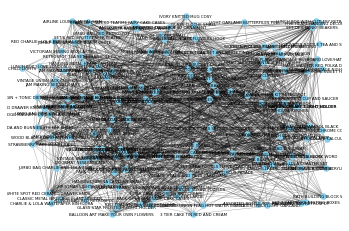

In [26]:
#Create Graph object using the weighted product matrix as adjacency matrix
G = nx.from_numpy_matrix(products_weighted)
pos=nx.random_layout(G)
labels = {}
for idx, node in enumerate(G.nodes()):
    labels[node] = nodes_labels[idx]

nx.draw_networkx_nodes(G, pos , node_color="skyblue", node_size=30)
nx.draw_networkx_edges(G, pos,  edge_color='k', width= 0.3, alpha= 0.5)
nx.draw_networkx_labels(G, pos, labels, font_size=4)
plt.axis('off')
plt.show() # display

In [31]:
#Find communities of nodes (products)
partition = community_louvain.best_partition(G, resolution = 1.5)
values = list(partition.values())

In [32]:
#Check how many communities were created
print('Number of communities:', len(np.unique(values)))

Number of communities: 10


In [33]:
#Create dataframe with product description and community id
products_communities = pd.DataFrame(nodes_labels, columns = ['product_description'])
products_communities['community_id'] = values

In [34]:
products_communities[products_communities['community_id']==1].head(15)


,product_description,community_id
1,EDWARDIAN PARASOL RED,1
6,VINTAGE BILLBOARD LOVE/HATE MUG,1
7,VINTAGE BILLBOARD DRINK ME MUG,1
26,GLASS STAR FROSTED T-LIGHT HOLDER,1
35,SAVE THE PLANET MUG,1
79,HAND WARMER RED POLKA DOT,1
80,HAND WARMER UNION JACK,1
95,SET 7 BABUSHKA NESTING BOXES,1
117,RETRO COFFEE MUGS ASSORTED,1
120,WHITE METAL LANTERN,1


In [35]:
#Lets now divide each element in products_weighted dataframe with the maximum of each row.
#This will normalize values in the row and we can perceive it as the possibility af a customer also buying
#product in column j after showing interest for the product in row i

#Turn into dataframe
products_weighted_pd = pd.DataFrame(products_weighted, columns = nodes_labels)
products_weighted_pd.set_index(products_weighted_pd.columns, 'product', inplace=True)

products_prob = products_weighted_pd.divide(products_weighted_pd.max(axis = 1), axis = 0)

In [37]:
products_prob

,INFLATABLE POLITICAL GLOBE,EDWARDIAN PARASOL RED,STRAWBERRY CHARLOTTE BAG,LUNCH BAG RED RETROSPOT,JUMBO BAG CHARLIE AND LOLA TOYS,SET/2 RED RETROSPOT TEA TOWELS,VINTAGE BILLBOARD LOVE/HATE MUG,VINTAGE BILLBOARD DRINK ME MUG,SET/6 RED SPOTTY PAPER PLATES,ROSE CARAVAN DOORSTOP,...,SMALL HEART FLOWERS HOOK,RED 3 PIECE RETROSPOT CUTLERY SET,BLUE 3 PIECE POLKADOT CUTLERY SET,TRADITIONAL CHRISTMAS RIBBONS,RED CHARLIE+LOLA PERSONAL DOORSIGN,JUMBO BAG RED RETROSPOT,JUMBO BAG BAROQUE BLACK WHITE,WHITE HANGING HEART T-LIGHT HOLDER,CHARLIE & LOLA WASTEPAPER BIN FLORA,POSTAGE
INFLATABLE POLITICAL GLOBE,0.00000,0.0,0.000000,0.000000,0.000000,0.612245,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.612245
EDWARDIAN PARASOL RED,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.000000,0.000000
STRAWBERRY CHARLOTTE BAG,0.00000,0.0,0.000000,1.000000,1.000000,0.000000,0.0,0.0,1.000000,0.0,...,0.0,1.000000,1.000000,0.0,1.000000,0.0,0.837209,0.0,1.000000,0.000000
LUNCH BAG RED RETROSPOT,0.00000,0.0,1.000000,0.000000,1.000000,0.000000,0.0,0.0,1.000000,0.0,...,0.0,1.000000,1.000000,0.0,1.000000,0.0,0.837209,0.0,1.000000,0.000000
JUMBO BAG CHARLIE AND LOLA TOYS,0.00000,0.0,1.000000,1.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,...,0.0,1.000000,1.000000,0.0,1.000000,0.0,0.837209,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JUMBO BAG RED RETROSPOT,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.437500,0.0,0.000000,0.000000
JUMBO BAG BAROQUE BLACK WHITE,0.00000,0.0,0.744186,0.744186,0.744186,0.000000,0.0,0.0,0.744186,0.0,...,0.0,0.744186,0.744186,0.0,0.744186,1.0,0.000000,0.0,0.744186,0.000000
WHITE HANGING HEART T-LIGHT HOLDER,0.00000,1.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
CHARLIE & LOLA WASTEPAPER BIN FLORA,0.00000,0.0,1.000000,1.000000,1.000000,0.000000,0.0,0.0,1.000000,0.0,...,0.0,1.000000,1.000000,0.0,1.000000,0.0,0.837209,0.0,0.000000,0.000000


In [42]:
#Now lets select a hypothetical basket of goods (one or more products) that a customer has already purchased or
#shown an interest for by clicking on an add or something, and then suggest him relative ones
basket = ['HOME BUILDING BLOCK WORD']
#Also select the number of relevant items to suggest
no_of_suggestions = 5

all_of_basket = products_prob[basket]
all_of_basket = all_of_basket.sort_values(by = basket, ascending=False)
suggestions_to_customer = list(all_of_basket.index[:no_of_suggestions])

print('You may also consider buying:', suggestions_to_customer)

You may also consider buying: ['LOVE BUILDING BLOCK WORD', 'DOORMAT FANCY FONT HOME SWEET HOME', 'RECIPE BOX WITH METAL HEART', 'BOX OF 6 ASSORTED COLOUR TEASPOONS', 'BLUE COAT RACK PARIS FASHION']


array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.61904762],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [       nan],
       [0.        ],
       [0.        ],
       [0.61904762],
       [0.61904762],
       [0.78666667],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.71111111],
       [0.71111111],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

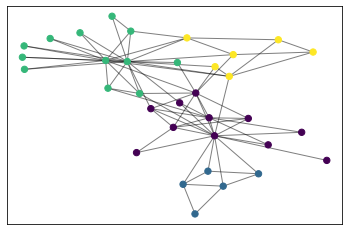

In [20]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

# load the karate club graph
G = nx.karate_club_graph()

#first compute the best partition
partition = community_louvain.best_partition(G)

# compute the best partition
partition = community_louvain.best_partition(G)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()